## Easy

Взять один файл с маркой машины.

Построить прогноз, используя модели линейной регрессии и случайного леса. Сравнить результаты, используя кросс-валидацию. Подобрать гиперпараметры моделей (для линейной регрессии можно использовать реализацию с градиентным спуском `SGDRegressor`). Оценить качество, используя метрику `r2_score`. Оценить важность признаков (параметр `feature_importance_` у случайного леса).

In [131]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot
from sklearn.linear_model import SGDRegressor

In [132]:
df = pd.read_csv('data/cars/ford.csv')
df = pd.DataFrame(df)
df = df.dropna()
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


In [133]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000
mean,2016.866574,12279.756415,23363.630504,113.334539,57.906991,1.350827
std,2.050346,4741.382606,19472.114690,62.010438,10.125977,0.432371
min,1996.000000,495.000000,1.000000,0.000000,20.800000,0.000000
25%,2016.000000,8999.000000,9987.000000,30.000000,52.300000,1.000000
50%,2017.000000,11291.000000,18243.000000,145.000000,58.900000,1.200000
75%,2018.000000,15299.000000,31064.000000,145.000000,65.700000,1.500000
max,2060.000000,54995.000000,177644.000000,580.000000,201.800000,5.000000


Обработка категориальных признаков

In [134]:
df_new = pd.get_dummies(df)
df_new

,year,price,mileage,tax,mpg,engineSize,model_ B-MAX,model_ C-MAX,model_ EcoSport,model_ Edge,...,model_ Tourneo Custom,model_ Transit Tourneo,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,12000,15944,150,57.7,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2018,14000,9083,150,57.7,1.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2017,13000,12456,150,57.7,1.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,2019,17500,10460,145,40.3,1.5,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2019,16500,1482,145,48.7,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17960,2016,7999,31348,125,54.3,1.2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
17961,2017,8999,16700,150,47.1,1.4,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
17962,2014,7499,40700,30,57.7,1.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
17963,2015,9999,7010,20,67.3,1.6,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [135]:
df_total = (df_new - df_new.mean()) / df_new.std()
df_total

,year,price,mileage,tax,mpg,engineSize,model_ B-MAX,model_ C-MAX,model_ EcoSport,model_ Edge,...,model_ Tourneo Custom,model_ Transit Tourneo,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.065075,-0.059003,-0.381039,0.591279,-0.020442,-0.811401,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,3.492732,-2.517596,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
1,0.552798,0.362815,-0.733389,0.591279,-0.020442,-0.811401,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
2,0.065075,0.151906,-0.560167,0.591279,-0.020442,-0.811401,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
3,1.040520,1.100996,-0.662672,0.510647,-1.738794,0.345012,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
4,1.040520,0.890087,-1.123742,0.510647,-0.909245,-0.811401,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,3.492732,-2.517596,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17960,-0.422648,-0.902850,0.410041,0.188121,-0.356212,-0.348836,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
17961,0.065075,-0.691941,-0.342214,0.591279,-1.067254,0.113730,7.042931,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
17962,-1.398093,-1.008304,0.890318,-1.343879,-0.020442,-0.811401,7.042931,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,-0.687134,-0.010551,-0.035015,-0.007461,0.689329
17963,-0.910370,-0.481032,-0.839849,-1.505142,0.927615,0.576295,-0.141978,-0.176538,-0.260659,-0.108227,...,-0.062092,-0.007461,-0.286293,0.397182,-0.253771,1.455240,-0.010551,-0.035015,-0.007461,-1.450605


Разобьем выборку на test и train

In [136]:
targets = np.array(df_total['price'])

In [137]:
df = df_total.drop('price', axis = 1)

In [138]:
df = np.array(df)

In [139]:
x_train, x_test, y_train, y_test = train_test_split(df, targets, test_size = 0.50, random_state = 42)

Построим модель случайного леса

In [140]:
model = RandomForestRegressor(n_estimators = 250, max_depth = 15)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_score(y_pred, y_test)

0.9226208370016925

Кросс-валидация

In [141]:
cross_val = cross_val_score(model, x_train, y_train)
print('RandomForestRegressor')
print('Кросс-валидация на треин выборке:', cross_val)
print('Среднее по кросс-валидации:', cross_val.mean())

print('Качество на тестовой выборке:', r2_score(y_test, y_pred))

RandomForestRegressor
Кросс-валидация на треин выборке: [0.93167517 0.92849147 0.93863606 0.92458984 0.92729803]
Среднее по кросс-валидации: 0.930138112809842
Качество на тестовой выборке: 0.9286570374484491


Подбор гиперпараметров для модели RandomForestRegressor

In [142]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [143]:
params = {
    'n_estimators': [10, 100, 250],
    'max_depth': [5, 15, 20]
}

In [144]:
search = GridSearchCV(RandomForestRegressor(), params)
search.fit(x_train, y_train)
search.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=250)

Оценить важность признаков (параметр feature_importance_ у случайного леса)

In [145]:
model.feature_importances_

array([5.03084181e-01, 5.91028958e-02, 5.71320486e-03, 6.60039990e-02,
       2.42871452e-01, 5.58067332e-04, 1.00047722e-03, 2.17073533e-03,
       1.11792957e-02, 2.53118183e-07, 2.04795298e-02, 5.53385086e-03,
       1.15630213e-05, 1.76321030e-03, 3.54645927e-04, 8.60268413e-04,
       3.41017805e-03, 1.82946320e-02, 2.97809569e-02, 1.64527406e-03,
       1.03694831e-02, 3.58529154e-03, 0.00000000e+00, 3.70648860e-03,
       0.00000000e+00, 3.84831705e-04, 5.15777554e-04, 0.00000000e+00,
       1.41482118e-03, 2.76461691e-03, 1.78246226e-03, 9.37364374e-04,
       0.00000000e+00, 1.78742833e-04, 9.89829194e-07, 5.40459242e-04])

Feature: 0, Score: 0.50308
Feature: 1, Score: 0.05910
Feature: 2, Score: 0.00571
Feature: 3, Score: 0.06600
Feature: 4, Score: 0.24287
Feature: 5, Score: 0.00056
Feature: 6, Score: 0.00100
Feature: 7, Score: 0.00217
Feature: 8, Score: 0.01118
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.02048
Feature: 11, Score: 0.00553
Feature: 12, Score: 0.00001
Feature: 13, Score: 0.00176
Feature: 14, Score: 0.00035
Feature: 15, Score: 0.00086
Feature: 16, Score: 0.00341
Feature: 17, Score: 0.01829
Feature: 18, Score: 0.02978
Feature: 19, Score: 0.00165
Feature: 20, Score: 0.01037
Feature: 21, Score: 0.00359
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00371
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00038
Feature: 26, Score: 0.00052
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00141
Feature: 29, Score: 0.00276
Feature: 30, Score: 0.00178
Feature: 31, Score: 0.00094
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00018
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00054


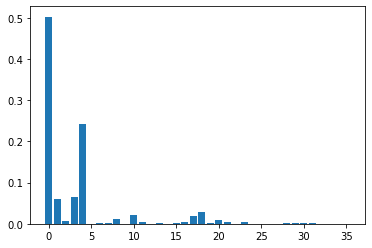

In [146]:
importance = model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

SGDRegressor

In [147]:
model_sgd = SGDRegressor(alpha=0.0001, eta0=0.0001, penalty='l1', power_t=0.25, shuffle=False,
       verbose=0, warm_start=False)
model_sgd.fit(x_train, y_train)
y_pred_sgd = model_sgd.predict(x_test)
r2_score(y_pred_sgd, y_test)

0.7229801853206952

In [148]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.1, 0.001, 0.0001],
    'max_iter': [100, 500, 1000],
    'eta0': [0.1, 0.0001]
}

r_search = RandomizedSearchCV(SGDRegressor(), params)
r_search.fit(x_train, y_train)
r_search.best_estimator_

SGDRegressor(eta0=0.0001, max_iter=100, penalty='elasticnet')

In [149]:
r_search.best_score_

0.8128411627017973

Кросс-валидация

In [150]:
cross_val = cross_val_score(model_sgd, x_train, y_train)
print('SGDRegressor')
print('Кросс-валидация на треин выборке:', cross_val)
print('Среднее по кросс-валидации:', cross_val.mean())

print('Качество на тестовой выборке:', r2_score(y_test, y_pred_sgd))

SGDRegressor
Кросс-валидация на треин выборке: [0.81726377 0.8140909  0.83438525 0.77331249 0.82618439]
Среднее по кросс-валидации: 0.813047360476333
Качество на тестовой выборке: 0.8168817570865392


In [151]:
model_sgd.coef_

array([ 0.3359098 , -0.27338712,  0.0953264 , -0.12926755,  0.1476044 ,
       -0.0600874 , -0.04542353, -0.01762935,  0.1169995 ,  0.00547777,
       -0.1109576 ,  0.06704718, -0.0151751 ,  0.0671564 , -0.01712027,
        0.01127511, -0.05928203, -0.1277986 ,  0.08810545,  0.00187138,
        0.12656748,  0.07165184,  0.        ,  0.0755478 ,  0.        ,
        0.00580674,  0.0499146 ,  0.        ,  0.03491044, -0.03454076,
        0.01085838,  0.05797877,  0.        ,  0.03048151,  0.00242024,
       -0.06024679])

Feature: 0, Score: 0.33591
Feature: 1, Score: -0.27339
Feature: 2, Score: 0.09533
Feature: 3, Score: -0.12927
Feature: 4, Score: 0.14760
Feature: 5, Score: -0.06009
Feature: 6, Score: -0.04542
Feature: 7, Score: -0.01763
Feature: 8, Score: 0.11700
Feature: 9, Score: 0.00548
Feature: 10, Score: -0.11096
Feature: 11, Score: 0.06705
Feature: 12, Score: -0.01518
Feature: 13, Score: 0.06716
Feature: 14, Score: -0.01712
Feature: 15, Score: 0.01128
Feature: 16, Score: -0.05928
Feature: 17, Score: -0.12780
Feature: 18, Score: 0.08811
Feature: 19, Score: 0.00187
Feature: 20, Score: 0.12657
Feature: 21, Score: 0.07165
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.07555
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00581
Feature: 26, Score: 0.04991
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.03491
Feature: 29, Score: -0.03454
Feature: 30, Score: 0.01086
Feature: 31, Score: 0.05798
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.03048
Feature: 34, Score: 0.00242
Feature: 35, Score:

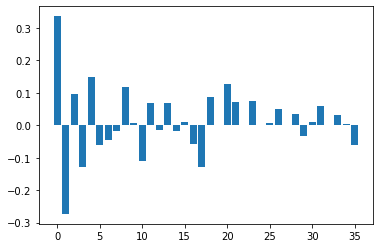

In [152]:
importance = model_sgd.coef_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Normal

Объединить в один датафрейм данные по всем маркам машин. Преобразовать категориальные признаки.

Построить еще несколько моделей, используя подбор гиперпараметров. Сравнить между собой все построенные модели.